# Chap07.
## CNN, Convolutional Neural Network
### 이미지 처리 분야에서 가장 유명한 신경망 모델인 CNN을 이용하여 더 높은 인식률을 만들어 봄

In [2]:
import tensorflow as tf 

from tensorflow.examples.tutorials.mnist import input_data

In [3]:
# 1. 데이터 로드
#  - Tensorflow에 기본 내장된 mnist 모듈을 이용하여 데이터를 로드
#  - 지정한 폴더에 MNIST 데이터가 없는 경우 자동으로 데이터를 다운로드함
#  - one-hot 옵션은 Label을 one-hot vector로 만들어 줌
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [3]:
# 2. 신경망 모델 구성
#  - 기존 모델에서는 입력값을 28x28(784)하나의 차원으로 구성하였으나,
#  - CNN 모델을 사용하기 위해 2차원 평면과 특성치의 형태를 갖는 구조로 만듦
#  Input -> Conv 1st layer -> Conv 2nd layer -> FC -> Output

# 1) Input(X), Label(Y) 설정
#   - X: 
#       > 첫번째 차원인 None은 Batch size
#       > 마지막 차원인 채널은 특징의 개수로, MNIST 데이터는 회색조 이미지이기 때문에,
#         채널에 색상이 1개이므로 1을 사용
# 
#   - keep_prob:
#       > Dropout을 위한 placeholder

X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

# 2) CNN 레이어 구성

# 1st layer - Conv Layer
#  - W1: [3, 3, 1, 32] -> [3, 3]: 커널(필터) 크기, 1: X의 특성수, 32: 커널(필터) 개수
#  - Conv의 shape=(?, 28, 28, 32) -> ?: batch, [28, 28]: Map size, 32: 커널 개수
#  - pool의 shape=(?, 14, 14, 32) -> ?: batch, [14, 14]: Map size, 32: 커널 개수
# tf.name_scope()를 이용해 텐서보드에서 한 계층 내부를 표현해줌

W1 = tf.get_variable(name='W1', shape=[3, 3, 1, 32], 
                    initializer=tf.contrib.layers.xavier_initializer_conv2d())

print('W1의 구조: {}'.format(W1))

# tf.nn.conv2d를 이용해 Stride=1인 컨볼루션 레이어를 쉽게 만들 수 있음
# padding='SAME'으로 padding 사용 설정 
# https://www.tensorflow.org/api_docs/python/tf/nn/conv2d 참고
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
print('L1(conv)의 구조: {}'.format(L1))
L1 = tf.nn.relu(L1)

# Pooling 또한 tf.nn.max_pool(최대 풀링)을 이용하여 쉽게 구성할 수 있음
# https://www.tensorflow.org/api_docs/python/tf/nn/max_pool 참고
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('L1(pooling)의 구조: {}'.format(L1))
# L1 = tf.nn.dropout(L1, keep_prob)

W1의 구조: <tf.Variable 'W1:0' shape=(3, 3, 1, 32) dtype=float32_ref>
L1(conv)의 구조: Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
L1(pooling)의 구조: Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)


In [4]:
# 2nd layer - Conv Layer
# L2 Conv shape = (?, 14, 14, 64)
# W2의 [3, 3, 32, 64]에서 32는 L1 에서 출력된 W1의 마지막 차원 즉, 커널의 개수, 

W2 = tf.get_variable(name='W2', shape=[3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer_conv2d())
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('L2(pooling)의 구조: {}'.format(L2))
# L2 = tf.nn.dropout(L2, keep_prob)

L2(pooling)의 구조: Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)


In [5]:
# 3rd layer - FC(Fully Connected) layer
# 10개의 분류를 만들어내는 계층을 구성
# 10개의 분류는 1차원 배열이므로 차원을 줄이는 단계를 거쳐야함
# Full Connect를 위해 L2의 pooling의 사이즈인 (?, 7, 7, 64)를 참고하여 차원을 줄여줌
# tf.reshape()를 이용해 7x7x64 크기의 1차원으로 만들어줌
W3 = tf.get_variable(name='W3', shape=[7*7*64, 256], initializer=tf.contrib.layers.xavier_initializer())
L3 = tf.reshape(L2, [-1, 7*7*64])
L3 = tf.matmul(L3, W3)
L3 = tf.nn.relu(L3)
# L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

In [6]:
# 4th layer
# L3에서의 출력값 256개를 입력값으로 받아 0~9 레이블은 10개의 출력값을 만듦
W4 = tf.get_variable(name='W4', shape=[256, 10], initializer=tf.contrib.layers.xavier_initializer())
model = tf.matmul(L3, W4)

In [8]:
# 3) 손실함수 설정

cost = tf.losses.softmax_cross_entropy(logits=model, onehot_labels=Y)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [16]:
# 3. CNN 모델 학습

# 1) 세션 초기화
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# 2) Batch size 설정
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)

# 3) 최적화 진행
for epoch in range(5):
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # 이미지 데이터를 CNN 모델을 위한 자료형태인 [28, 28, 1]의 형태로 재구성함
        batch_xs = batch_xs.reshape([-1, 28, 28, 1])
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch + 1),
         'Avg. cost= {:.3f}'.format(total_cost / total_batch))

print('최적화 완료!')

Epoch: 0001 Avg. cost= 0.168
Epoch: 0002 Avg. cost= 0.047
Epoch: 0003 Avg. cost= 0.034
Epoch: 0004 Avg. cost= 0.025
Epoch: 0005 Avg. cost= 0.017
최적화 완료!


In [24]:
# 4. 결과 확인
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels, keep_prob: 1}))

정확도: 0.9909


## 필터 시각화하기

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    print(FH, FW, C, FN)
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

In [32]:
print('W1의 구조: {}'.format(W1))

W1의 구조: <tf.Variable 'W1:0' shape=(3, 3, 1, 32) dtype=float32_ref>


32 1 3 3


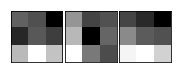

In [39]:
kernel = sess.run(W1)
filter_show(kernel.transpose(3,2,0,1))

In [9]:
batch_xs, batch_ys = mnist.train.next_batch(100)
        # 이미지 데이터를 CNN 모델을 위한 자료형태인 [28, 28, 1]의 형태로 재구성함
batch_xs = batch_xs.reshape([-1,28, 28, 1])

In [8]:
batch_xs.shape

(100, 784)